## Genome Space analysis of MURINE ONT dataset after correction

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import joblib
import pysam
from tqdm import tqdm

sys.path.append("/lustrehome/afonzino")

from C_to_U_classifier_plus_min import utils
from C_to_U_classifier_plus_min.utils import create_sequence_logo, get_rev_compl

### --- utils functions --- ################
def retrieve_depth_stranded(bam_file, region, pos1based, strand):
    pos0based=pos1based-1
    for pileupcolumn in bam_file.pileup(region, pos0based, pos0based+1, truncate=True, max_depth=1000000, min_base_quality=0):
        column = pileupcolumn.get_query_sequences(mark_matches=True, add_indels=True)
        if strand == "+":
            depth_stranded = sum(1 for b in column if b.isupper())
        elif strand == "-":
            depth_stranded = sum(1 for b in column if b.islower())
    return depth_stranded


def produce_consensus(df, title, interval, ref_filepath):
    with tqdm(total=df.shape[0]) as pbar:
        refs = []
        ref = pysam.FastaFile(ref_filepath)
        for site in df.itertuples():
            region = site[1]
            pos1based = site[2]
            pos0based = pos1based-1
            strand = site[3]
            reference = ref.fetch(region, pos0based-interval, pos0based+interval+1)
            if strand == "+":
                refs.append(list(reference))
            elif strand == "-":
                reference = get_rev_compl(reference)
                refs.append(list(reference))
            pbar.update(1)
    ref.close()
    
    refs = pd.DataFrame(refs, columns=[f"{i}" for i in range(interval*2+1)])
    refs_freqs = {}
    for rel_pos in refs:
        refs_freqs[int(rel_pos)] = refs[rel_pos].value_counts().sort_index()
    refs = pd.DataFrame(refs_freqs).fillna(0)
    depths = refs.sum().tolist()
    refs = refs / depths
    refs = refs.T

    create_sequence_logo(refs, title=f"{title}")

############################################

In [2]:
# load models
sc = joblib.load("/lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/standard_scaler_no_mims_indels_cc1_wt_ko_21072022.joblib")
clf = joblib.load("/lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/iforest_no_mism_indels_cc1_wt_ko_21072022.joblib")

In [3]:
# load encoded datasets
dfCT_wt_enc = pd.read_table("/lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/dfCT_predicted_wt.tsv")
dfCT_ko_enc = pd.read_table("/lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/dfCT_predicted_ko.tsv")
print("WT")
print(dfCT_wt_enc)
print("KO")
print(dfCT_ko_enc)

WT
        region   position                             read_name strand  Tqual  \
0         chr5    3286403  f3b597d8-2821-4d25-8c35-dc65bcf46e0a      +    4.0   
1         chr5    3286403  244767df-eb4a-40fb-b1da-7cb3a6d792f5      +    9.0   
2         chr5    3286407  e8c9bc21-bfb9-47cb-92df-a9ca2f12cc8c      +    7.0   
3         chr5    3286410  1d0cd8af-4469-447f-807a-05143e9c0325      +    6.0   
4         chr5    3286410  7bf3c277-bb64-4be0-8e49-71a76857728a      +    5.0   
...        ...        ...                                   ...    ...    ...   
3978421  chr13  120169593  87ea5e75-10e9-4a82-a428-1b070b4b3acc      +   13.0   
3978422  chr13  120169593  4eac5795-fb82-4151-ba25-673385aafcbe      +    6.0   
3978423  chr13  120169593  e0b38f22-c16a-4af7-a006-0f939379379d      +    4.0   
3978424  chr13  120169593  68621b59-d975-492c-8334-dcc133b05434      +    4.0   
3978425  chr13  120169593  a4fb3463-68a0-4bfb-98de-a8fbb457469d      +    6.0   

         MeanQual  n_mis

In [4]:
# filter indels and mismatches
dfCT_wt_enc_filt = dfCT_wt_enc.query("n_ins <= 0").query("n_dels <= 0").query("n_mismatches <= 0").copy()
dfCT_ko_enc_filt = dfCT_ko_enc.query("n_ins <= 0").query("n_dels <= 0").query("n_mismatches <= 0").copy()

# prediction by iforest
# predict with iforest after scaling to z-scores
dfCT_wt_enc_filt["y_hat"] = clf.predict(sc.transform(dfCT_wt_enc_filt.iloc[:,4:6]))
dfCT_ko_enc_filt["y_hat"] = clf.predict(sc.transform(dfCT_ko_enc_filt.iloc[:,4:6]))

In [5]:
# WT
# aggregate data on genome space before and after correction for both wt and ko samples
dfCT_wt_enc_genomespace_native = dfCT_wt_enc.groupby(["region", "position", "strand"]).size().to_frame(name="T_native").reset_index()
# corrected are both without mism., indels and predcted as novelty by iforest
dfCT_wt_enc_genomespace_corrected = dfCT_wt_enc_filt.query("y_hat == -1").groupby(["region", "position", "strand"]).size().to_frame(name="T_corrected").reset_index()
# aggregates native and corrected data for WT and KO separately.
dfCT_wt_aggregated = pd.merge(dfCT_wt_enc_genomespace_native, 
                              dfCT_wt_enc_genomespace_corrected,
                              how="left")
dfCT_wt_aggregated.fillna(0, inplace=True)
print("\nWT\n", dfCT_wt_aggregated)

# KO
dfCT_ko_enc_genomespace_native = dfCT_ko_enc.groupby(["region", "position", "strand"]).size().to_frame(name="T_native").reset_index()
dfCT_ko_enc_genomespace_corrected = dfCT_ko_enc_filt.query("y_hat == -1").groupby(["region", "position", "strand"]).size().to_frame(name="T_corrected").reset_index()
dfCT_ko_aggregated = pd.merge(dfCT_ko_enc_genomespace_native, 
                              dfCT_ko_enc_genomespace_corrected,
                              how="left")
dfCT_ko_aggregated.fillna(0, inplace=True)
print("\n\nKO\n", dfCT_ko_aggregated)


WT
        region  position strand  T_native  T_corrected
0        chr1   4846611      -         2          0.0
1        chr1   4846619      -         1          0.0
2        chr1   4846635      -         5          0.0
3        chr1   4846643      -         3          0.0
4        chr1   4846645      -         3          0.0
...       ...       ...    ...       ...          ...
389965   chrY  90804626      +         2          0.0
389966   chrY  90804632      +         1          0.0
389967   chrY  90804649      +         1          0.0
389968   chrY  90804680      +         2          0.0
389969   chrY  90804681      +         1          0.0

[389970 rows x 5 columns]


KO
        region  position strand  T_native  T_corrected
0        chr1   4846611      -         2          0.0
1        chr1   4846619      -         2          0.0
2        chr1   4846635      -         7          0.0
3        chr1   4846643      -         2          0.0
4        chr1   4846645      -         4    

In [6]:
# takes only reads that after the correction have at least one T base
# WT
dfCT_wt_aggregated = dfCT_wt_aggregated.query("T_corrected > 1")
dfCT_wt_aggregated

,region,position,strand,T_native,T_corrected
103,chr1,4855906,-,58,18.0
114,chr1,4915375,+,3,2.0
120,chr1,4915467,+,5,3.0
136,chr1,4915694,+,7,3.0
169,chr1,4916144,+,4,2.0
...,...,...,...,...,...
389709,chrY,20671561,+,84,30.0
389730,chrY,20671676,+,76,18.0
389732,chrY,20671681,+,95,9.0
389737,chrY,20671750,+,83,30.0


In [7]:
# takes only reads that after the correction have at least one T base
# KO
dfCT_ko_aggregated = dfCT_ko_aggregated.query("T_corrected > 1")
dfCT_ko_aggregated

,region,position,strand,T_native,T_corrected
128,chr1,4855906,-,70,15.0
453,chr1,4963679,+,3,2.0
471,chr1,4966611,+,10,3.0
498,chr1,4966890,+,23,3.0
1271,chr1,10108102,-,46,5.0
...,...,...,...,...,...
527387,chrY,20671793,+,112,2.0
527418,chrY,20672082,+,107,35.0
527632,chrY,90797180,+,4,2.0
527684,chrY,90827645,+,39,22.0


In [8]:
# retrieve stranded depths for each position
# start computation
# WT
bam_filepath = "/lustre/bio_running/C_to_U_editing_minimap2_spliced/wt.bam"
bam = pysam.AlignmentFile(bam_filepath) # opening bamfile via pysam
depths_stranded = []
with tqdm(total=dfCT_wt_aggregated.shape[0]) as pbar:
    for s in dfCT_wt_aggregated.itertuples():
        try:
            d = retrieve_depth_stranded(bam, s.region, s.position, s.strand)
        except UnboundLocalError:
            d = 0
        depths_stranded.append(d)
        pbar.update(1)
bam.close()
# append depths_stranded columns to final dataframe of aggregated data
dfCT_wt_aggregated["depth_stranded"] = depths_stranded
# retain only sites with a depth higher than 50
dfCT_wt_aggregated = dfCT_wt_aggregated.query("depth_stranded > 50").fillna(0)
# produce frequencies
dfCT_wt_aggregated["Tfreq_native"] = dfCT_wt_aggregated["T_native"] / dfCT_wt_aggregated["depth_stranded"]
dfCT_wt_aggregated["Tfreq_corrected"] = dfCT_wt_aggregated["T_corrected"] / dfCT_wt_aggregated["depth_stranded"]
print("\nWT\n", dfCT_wt_aggregated)

# KO
bam_filepath = "/lustre/bio_running/C_to_U_editing_minimap2_spliced/ko.bam"
bam = pysam.AlignmentFile(bam_filepath) # opening bamfile via pysam
depths_stranded = []
with tqdm(total=dfCT_ko_aggregated.shape[0]) as pbar:
    for s in dfCT_ko_aggregated.itertuples():
        try:
            d = retrieve_depth_stranded(bam, s.region, s.position, s.strand)
        except UnboundLocalError:
            d = 0
        depths_stranded.append(d)
        pbar.update(1)
bam.close()

# append depths_stranded columns to final dataframe of aggregated data
dfCT_ko_aggregated["depth_stranded"] = depths_stranded
# retain only sites with a depth higher than 50
dfCT_ko_aggregated = dfCT_ko_aggregated.query("depth_stranded > 50").fillna(0)
# produce frequencies
dfCT_ko_aggregated["Tfreq_native"] = dfCT_ko_aggregated["T_native"] / dfCT_ko_aggregated["depth_stranded"]
dfCT_ko_aggregated["Tfreq_corrected"] = dfCT_ko_aggregated["T_corrected"] / dfCT_ko_aggregated["depth_stranded"]
print("\nKO\n", dfCT_ko_aggregated)

100%|██████████| 6680/6680 [11:16<00:00,  9.87it/s]



WT
        region  position strand  T_native  T_corrected  depth_stranded  \
103      chr1   4855906      -        58         18.0              61   
114      chr1   4915375      +         3          2.0              51   
120      chr1   4915467      +         5          3.0              55   
136      chr1   4915694      +         7          3.0              51   
169      chr1   4916144      +         4          2.0              62   
...       ...       ...    ...       ...          ...             ...   
389709   chrY  20671561      +        84         30.0              95   
389730   chrY  20671676      +        76         18.0              89   
389732   chrY  20671681      +        95          9.0             110   
389737   chrY  20671750      +        83         30.0             107   
389774   chrY  20672082      +       103         21.0             112   

        Tfreq_native  Tfreq_corrected  
103         0.950820         0.295082  
114         0.058824         0.039216 

100%|██████████| 7325/7325 [10:49<00:00, 11.28it/s]


KO
        region  position strand  T_native  T_corrected  depth_stranded  \
128      chr1   4855906      -        70         15.0              70   
453      chr1   4963679      +         3          2.0             111   
471      chr1   4966611      +        10          3.0             111   
498      chr1   4966890      +        23          3.0             123   
1271     chr1  10108102      -        46          5.0             129   
...       ...       ...    ...       ...          ...             ...   
527387   chrY  20671793      +       112          2.0             123   
527418   chrY  20672082      +       107         35.0             118   
527632   chrY  90797180      +         4          2.0              95   
527684   chrY  90827645      +        39         22.0              59   
527694   chrY  90833582      +        38         22.0              56   

        Tfreq_native  Tfreq_corrected  
128         1.000000         0.214286  
453         0.027027         0.018018 

In [9]:
# takes only sites with a frequency higher than at least 0.01 after the correction and save them to disk
# CtoU editing sites candidates
dfCT_wt_aggregated_candidates = dfCT_wt_aggregated.query("Tfreq_corrected > 0.01")
print("\nWT CtoU editing site candidates\n", dfCT_wt_aggregated_candidates)
dfCT_ko_aggregated_candidates = dfCT_ko_aggregated.query("Tfreq_corrected > 0.01")
print("\nKO CtoU editing site candidates\n", dfCT_ko_aggregated_candidates)


# save to disk
dfCT_wt_aggregated_candidates.to_csv("/lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/dfCT_wt_aggregated_candidates.tsv",
                                     sep="\t",
                                     index=None)

dfCT_ko_aggregated_candidates.to_csv("/lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/dfCT_ko_aggregated_candidates.tsv",
                                     sep="\t",
                                     index=None)


WT CtoU editing site candidates
        region  position strand  T_native  T_corrected  depth_stranded  \
103      chr1   4855906      -        58         18.0              61   
114      chr1   4915375      +         3          2.0              51   
120      chr1   4915467      +         5          3.0              55   
136      chr1   4915694      +         7          3.0              51   
169      chr1   4916144      +         4          2.0              62   
...       ...       ...    ...       ...          ...             ...   
389709   chrY  20671561      +        84         30.0              95   
389730   chrY  20671676      +        76         18.0              89   
389732   chrY  20671681      +        95          9.0             110   
389737   chrY  20671750      +        83         30.0             107   
389774   chrY  20672082      +       103         21.0             112   

        Tfreq_native  Tfreq_corrected  
103         0.950820         0.295082  
114      

In [10]:
dfCT_wt_aggregated_candidates.describe()

,position,T_native,T_corrected,depth_stranded,Tfreq_native,Tfreq_corrected
count,3.111000e+03,3111.000000,3111.000000,3111.000000,3111.000000,3111.000000
mean,8.046564e+07,89.193507,23.503375,253.741241,0.299313,0.077735
std,4.601631e+07,277.662232,115.327488,504.199891,0.314073,0.123796
min,5.733000e+03,2.000000,2.000000,51.000000,0.010345,0.010018
25%,4.131755e+07,9.000000,2.000000,82.000000,0.079208,0.016667
50%,7.921306e+07,21.000000,3.000000,128.000000,0.153061,0.027397
75%,1.183055e+08,65.000000,10.000000,215.000000,0.351553,0.055922
max,1.948122e+08,5792.000000,3575.000000,8969.000000,1.000000,0.745507


In [11]:
dfCT_ko_aggregated_candidates.describe()

,position,T_native,T_corrected,depth_stranded,Tfreq_native,Tfreq_corrected
count,3.541000e+03,3541.000000,3541.000000,3541.000000,3541.000000,3541.000000
mean,8.053318e+07,102.233832,25.794408,274.145157,0.334348,0.082167
std,4.614608e+07,305.674419,117.651449,591.402282,0.312136,0.130691
min,3.952000e+03,2.000000,2.000000,51.000000,0.011494,0.010025
25%,4.120330e+07,13.000000,2.000000,82.000000,0.109756,0.016529
50%,7.966360e+07,28.000000,3.000000,131.000000,0.192661,0.027273
75%,1.182892e+08,71.000000,11.000000,226.000000,0.447761,0.058824
max,1.947970e+08,8112.000000,3233.000000,16659.000000,1.000000,0.833333


In [12]:
dfCT_common = pd.merge(dfCT_ko_aggregated_candidates, dfCT_wt_aggregated_candidates, how="inner", on=["region", "position", "strand"], suffixes=["_ko", "_wt"])
dfCT_common

,region,position,strand,T_native_ko,T_corrected_ko,depth_stranded_ko,Tfreq_native_ko,Tfreq_corrected_ko,T_native_wt,T_corrected_wt,depth_stranded_wt,Tfreq_native_wt,Tfreq_corrected_wt
0,chr1,4855906,-,70,15.0,70,1.000000,0.214286,58,18.0,61,0.950820,0.295082
1,chr1,4966890,+,23,3.0,123,0.186992,0.024390,25,3.0,103,0.242718,0.029126
2,chr1,10108102,-,46,5.0,129,0.356589,0.038760,38,4.0,92,0.413043,0.043478
3,chr1,13635377,-,13,2.0,136,0.095588,0.014706,16,2.0,134,0.119403,0.014925
4,chr1,20873591,-,191,117.0,193,0.989637,0.606218,103,66.0,105,0.980952,0.628571
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1461,chrY,20671561,+,80,22.0,102,0.784314,0.215686,84,30.0,95,0.884211,0.315789
1462,chrY,20671676,+,78,16.0,104,0.750000,0.153846,76,18.0,89,0.853933,0.202247
1463,chrY,20671681,+,105,7.0,122,0.860656,0.057377,95,9.0,110,0.863636,0.081818
1464,chrY,20671750,+,93,31.0,121,0.768595,0.256198,83,30.0,107,0.775701,0.280374


In [13]:
dfCT_common.describe()

,position,T_native_ko,T_corrected_ko,depth_stranded_ko,Tfreq_native_ko,Tfreq_corrected_ko,T_native_wt,T_corrected_wt,depth_stranded_wt,Tfreq_native_wt,Tfreq_corrected_wt
count,1.466000e+03,1466.000000,1466.000000,1466.000000,1466.000000,1466.000000,1466.000000,1466.000000,1466.000000,1466.000000,1466.000000
mean,8.308319e+07,199.568213,55.716235,412.706685,0.483833,0.132770,164.025921,45.665757,341.948158,0.486178,0.131894
std,4.697704e+07,447.178759,178.423785,706.198397,0.344228,0.160501,387.385144,165.165124,673.679161,0.345470,0.157662
min,5.733000e+03,2.000000,2.000000,51.000000,0.020270,0.010032,2.000000,2.000000,51.000000,0.022222,0.010018
25%,4.250878e+07,30.000000,4.000000,112.250000,0.166667,0.022357,23.250000,3.000000,87.000000,0.163976,0.022923
50%,8.271926e+07,70.500000,11.000000,190.000000,0.318194,0.049063,60.000000,9.000000,146.000000,0.324988,0.048387
75%,1.226095e+08,181.750000,42.750000,379.000000,0.870378,0.219209,140.500000,34.000000,280.000000,0.875835,0.212753
max,1.851505e+08,8112.000000,3233.000000,8945.000000,1.000000,0.833333,5792.000000,3575.000000,8969.000000,1.000000,0.745507


In [14]:
from scipy.stats import spearmanr
spearmanr(dfCT_common["Tfreq_native_ko"], dfCT_common["Tfreq_native_wt"])

SpearmanrResult(correlation=0.9688831364935584, pvalue=0.0)

In [15]:
spearmanr(dfCT_common["Tfreq_corrected_ko"], dfCT_common["Tfreq_corrected_wt"])

SpearmanrResult(correlation=0.9155285866126414, pvalue=0.0)

In [16]:
# retrieve most reliable wt edited sites filtering
# out sites with editing evidence in WT after correction but without editing evidence in KO

bam_filepath = "/lustre/bio_running/C_to_U_editing_minimap2_spliced/ko.bam"
bam = pysam.AlignmentFile(bam_filepath) # opening bamfile via pysam
reliable_sites = []
with tqdm(total=dfCT_wt_aggregated_candidates.shape[0]) as pbar:    
    for candidate in dfCT_wt_aggregated_candidates.itertuples():
        if dfCT_ko_aggregated_candidates.query(f"region == '{candidate.region}'").query(f"position == {candidate.position}").query(f"strand == '{candidate.strand}'").empty:
            # assess if the ko sample was covered by minimum depth of 50
            try:
                d = retrieve_depth_stranded(bam, candidate.region, candidate.position, candidate.strand)
            except UnboundLocalError:
                d = 0
            
            if d > 50:
                reliable_sites.append(list(candidate)[1:])
        pbar.update(1)
bam.close()
reliable_sites = pd.DataFrame(reliable_sites, columns=dfCT_wt_aggregated_candidates.columns)
reliable_sites

100%|██████████| 3111/3111 [00:49<00:00, 62.23it/s] 


,region,position,strand,T_native,T_corrected,depth_stranded,Tfreq_native,Tfreq_corrected
0,chr1,4915375,+,3,2.0,51,0.058824,0.039216
1,chr1,4915467,+,5,3.0,55,0.090909,0.054545
2,chr1,4915694,+,7,3.0,51,0.137255,0.058824
3,chr1,4916144,+,4,2.0,62,0.064516,0.032258
4,chr1,4916361,+,4,2.0,67,0.059701,0.029851
...,...,...,...,...,...,...,...,...
1548,chrX,156228730,-,5,2.0,60,0.083333,0.033333
1549,chrX,158168468,+,5,3.0,132,0.037879,0.022727
1550,chrX,158168569,+,25,2.0,110,0.227273,0.018182
1551,chrX,161556464,+,5,2.0,145,0.034483,0.013793


In [17]:
ref_filepath = "/lustre/bio_running/C_to_U_editing/refs/GRCm39.primary_assembly.genome.fa"
ref = pysam.FastaFile(ref_filepath)
kmers = []
for site in reliable_sites.itertuples():
    kmer = ref.fetch(site.region, site.position-3, site.position+2)
    if site.strand == "+":
        kmers.append(kmer)
    elif site.strand == "-":
        kmers.append(utils.get_rev_compl(kmer))
ref.close()
reliable_sites["5mer"] = kmers

In [18]:
reliable_sites

,region,position,strand,T_native,T_corrected,depth_stranded,Tfreq_native,Tfreq_corrected,5mer
0,chr1,4915375,+,3,2.0,51,0.058824,0.039216,GACTA
1,chr1,4915467,+,5,3.0,55,0.090909,0.054545,TACAG
2,chr1,4915694,+,7,3.0,51,0.137255,0.058824,TACTA
3,chr1,4916144,+,4,2.0,62,0.064516,0.032258,TACTT
4,chr1,4916361,+,4,2.0,67,0.059701,0.029851,TACAT
...,...,...,...,...,...,...,...,...,...
1548,chrX,156228730,-,5,2.0,60,0.083333,0.033333,GACTT
1549,chrX,158168468,+,5,3.0,132,0.037879,0.022727,ATCTG
1550,chrX,158168569,+,25,2.0,110,0.227273,0.018182,CGCTA
1551,chrX,161556464,+,5,2.0,145,0.034483,0.013793,ATCTG


100%|██████████| 1553/1553 [00:00<00:00, 42854.49it/s]
findfont: Font family ['Arial Rounded MT Bold'] not found. Falling back to DejaVu Sans.


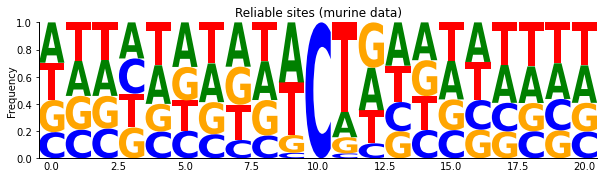

In [19]:
# produce consensus
produce_consensus(reliable_sites, "Reliable sites (murine data)", 10, ref_filepath)

In [20]:
# annotate with annovar
# lets produce a file to be annotated by annovar
output_filepaht = "/lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/reliable_ed_pos_murine_data.vcf"
with open(output_filepaht, "w") as out_vcf:
    for s in reliable_sites.itertuples():
        region = s.region.split("chr")[1]
        position = s.position
        strand = s.strand
        REF="C"
        ALT="T"
        if strand == "-": # cause of VCF file strand-less structure
            REF="G"
            ALT="A"
        site = f"{region}\t{position}\t{position}\t{REF}\t{ALT}\n"
        out_vcf.write(site)

!cat /lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/reliable_ed_pos_murine_data.vcf | head

1	4915375	4915375	C	T
1	4915467	4915467	C	T
1	4915694	4915694	C	T
1	4916144	4916144	C	T
1	4916361	4916361	C	T
1	4916384	4916384	C	T
1	4916406	4916406	C	T
1	4966872	4966872	C	T
1	4967044	4967044	C	T
1	4967193	4967193	C	T


In [21]:
# annotate vcf
!/lustrehome/afonzino/annovar/table_annovar.pl /lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/reliable_ed_pos_murine_data.vcf /lustrehome/afonzino/annovar/mousedb/ -buildver mm39 -out /lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/reliable_ed_pos_murine_data.annotated -protocol refGene -operation g -nastring . --remove -polish

-----------------------------------------------------------------
NOTICE: Processing operation=g protocol=refGene

NOTICE: Running with system command <annotate_variation.pl -geneanno -buildver mm39 -dbtype refGene -outfile /lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/reliable_ed_pos_murine_data.annotated.refGene -exonsort -nofirstcodondel /lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/reliable_ed_pos_murine_data.vcf /lustrehome/afonzino/annovar/mousedb/>
NOTICE: Output files are written to /lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/reliable_ed_pos_murine_data.annotated.refGene.variant_function, /lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismat

In [22]:
# load annotation and merge to reliable sites
reliable_sites_annotated = pd.concat([reliable_sites, 
                                      pd.read_table("/lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/reliable_ed_pos_murine_data.annotated.mm39_multianno.txt")], 
                                      axis=1).drop(["Chr", "Start", "End"], axis=1)
reliable_sites_annotated

,region,position,strand,T_native,T_corrected,depth_stranded,Tfreq_native,Tfreq_corrected,5mer,Ref,Alt,Func.refGene,Gene.refGene,GeneDetail.refGene,ExonicFunc.refGene,AAChange.refGene
0,chr1,4915375,+,3,2.0,51,0.058824,0.039216,GACTA,C,T,UTR3,Lypla1,NM_001355712:c.*136C>T;NM_008866:c.*136C>T,.,.
1,chr1,4915467,+,5,3.0,55,0.090909,0.054545,TACAG,C,T,UTR3,Lypla1,NM_001355712:c.*228C>T;NM_008866:c.*228C>T,.,.
2,chr1,4915694,+,7,3.0,51,0.137255,0.058824,TACTA,C,T,UTR3,Lypla1,NM_001355712:c.*455C>T;NM_008866:c.*455C>T,.,.
3,chr1,4916144,+,4,2.0,62,0.064516,0.032258,TACTT,C,T,UTR3,Lypla1,NM_001355712:c.*905C>T;NM_008866:c.*905C>T,.,.
4,chr1,4916361,+,4,2.0,67,0.059701,0.029851,TACAT,C,T,UTR3,Lypla1,NM_001355712:c.*1122C>T;NM_008866:c.*1122C>T,.,.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1548,chrX,156228730,-,5,2.0,60,0.083333,0.033333,GACTT,G,A,UTR3,Sms,NM_001359185:c.*403C>T;NM_009214:c.*403C>T,.,.
1549,chrX,158168468,+,5,3.0,132,0.037879,0.022727,ATCTG,C,T,UTR3,Eif1ax,NM_025437:c.*59C>T,.,.
1550,chrX,158168569,+,25,2.0,110,0.227273,0.018182,CGCTA,C,T,UTR3,Eif1ax,NM_025437:c.*160C>T,.,.
1551,chrX,161556464,+,5,2.0,145,0.034483,0.013793,ATCTG,C,T,exonic,Rbbp7,.,unknown,UNKNOWN


In [23]:
# remove not useful generate files
!rm /lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/reliable_ed_pos_murine_data.vcf
!rm /lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/reliable_ed_pos_murine_data.annotated.mm39_multianno.txt

In [24]:
# save reliable annotated edited sites
reliable_sites_annotated.to_csv("/lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/reliable_ed_pos_murine_data.tsv", 
                                sep="\t",
                                index=None)

In [25]:
reliable_sites_annotated["Func.refGene"].value_counts()

UTR3              894
exonic            517
intergenic         59
UTR5               28
intronic           23
ncRNA_exonic       15
ncRNA_intronic      9
downstream          6
upstream            2
Name: Func.refGene, dtype: int64

In [26]:
reliable_sites_annotated["Gene.refGene"].value_counts()

Atp6ap2         18
Selenof         18
Cmpk1           17
Sdcbp           15
Lamp2           14
                ..
Ehmt2            1
Lsm2             1
Clic1            1
Mrps18b          1
Gm21064;NONE     1
Name: Gene.refGene, Length: 794, dtype: int64

In [28]:
# assess how many reliable identified sites are supported by illumina sequencing
# load illumina gt sites
# focus only on reads of illumina ground truth sites for wt and ko runs
col_names = pd.read_table("/lustre/bio_running/C_to_U_editing/merged_mm39_columns.txt", header=None).T.values[0].tolist()
illumina_gt = pd.read_table("/lustre/bio_running/C_to_U_editing/merged_mm39.tsv", header=None, names=col_names)
illumina_gt

pd.merge(reliable_sites_annotated, illumina_gt, how="inner", left_on=["region", "position"], right_on=["contig_mm39", "pos_mm39"])

,region,position,strand_x,T_native,T_corrected,depth_stranded,Tfreq_native,Tfreq_corrected,5mer,Ref,...,"BaseCount_WT[A,C,G,T]",Subs_WT,SubsFreq_WT,cov_KO,MeanQual_KO,"BaseCount_KO[A,C,G,T]",Subs_KO,SubsFreq_KO,PositionAnnotation,gene_name
0,chr1,4915694,+,7,3.0,51,0.137255,0.058824,TACTA,C,...,"[0, 258, 0, 32]",CT,0.11,183,35.54,"[0, 183, 0, 0]",-,0.0,UTR3,Lypla1
1,chr1,4916384,+,13,2.0,65,0.200000,0.030769,TACTG,C,...,"[0, 164, 0, 19]",CT,0.10,134,35.85,"[0, 134, 0, 0]",-,0.0,UTR3,Lypla1
2,chr1,4967044,+,10,5.0,106,0.094340,0.047170,AACTA,C,...,"[0, 404, 0, 35]",CT,0.08,325,35.56,"[0, 325, 0, 0]",-,0.0,UTR3,Tcea1
3,chr1,13636029,-,12,2.0,128,0.093750,0.015625,TACTA,G,...,"[0, 526, 0, 50]",CT,0.09,337,35.57,"[0, 337, 0, 0]",-,0.0,UTR3,Tram1
4,chr1,37456656,-,7,2.0,79,0.088608,0.025316,GTCGT,G,...,"[0, 370, 0, 18]",CT,0.05,328,35.51,"[1, 327, 0, 0]",CA,0.0,UTR3,Coa5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,chrX,95211766,+,45,12.0,140,0.321429,0.085714,TACTT,C,...,"[0, 210, 0, 79]",CT,0.27,229,35.53,"[0, 229, 0, 0]",-,0.0,UTR3,Msn
122,chrX,108204658,+,11,4.0,72,0.152778,0.055556,AACGA,C,...,"[0, 367, 0, 50]",CT,0.12,295,35.10,"[0, 295, 0, 0]",-,0.0,UTR3,Sh3bgrl
123,chrX,108204953,+,7,2.0,72,0.097222,0.027778,TACTT,C,...,"[0, 623, 0, 32]",CT,0.05,462,35.44,"[0, 462, 0, 0]",-,0.0,UTR3,Sh3bgrl
124,chrX,108205780,+,12,3.0,99,0.121212,0.030303,AACAC,C,...,"[0, 527, 0, 84]",CT,0.14,478,35.22,"[0, 478, 0, 0]",-,0.0,UTR3,Sh3bgrl
